In [ ]:
# Sheva Haya Milano (105222036)
# Fitria Nurhaliza (105222035)
# Mini Project Klasifikasi gambar menggunakan model SVM

import os
import glob
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score

In [ ]:
### EDA

In [ ]:

# Path ke folder dataset
anemic_folder = "anemic"
nonanemic_folder = "nonanemic"

# Fungsi untuk membaca semua gambar dari folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images

# Membaca gambar dari kedua folder
anemic_images = load_images_from_folder(anemic_folder)
nonanemic_images = load_images_from_folder(nonanemic_folder)

print(f"Jumlah gambar anemic: {len(anemic_images)}")
print(f"Jumlah gambar non-anemic: {len(nonanemic_images)}")

# Analisis ukuran gambar
def analyze_image_sizes(images, category):
    heights = []
    widths = []
    channels = []
    
    for img in images:
        h, w, c = img.shape
        heights.append(h)
        widths.append(w)
        channels.append(c)
    
    return {
        'category': category,
        'count': len(images),
        'height_mean': np.mean(heights),
        'height_std': np.std(heights),
        'width_mean': np.mean(widths),
        'width_std': np.std(widths),
        'min_height': min(heights),
        'max_height': max(heights),
        'min_width': min(widths),
        'max_width': max(widths)
    }

anemic_stats = analyze_image_sizes(anemic_images, 'anemic')
nonanemic_stats = analyze_image_sizes(nonanemic_images, 'nonanemic')

stats_df = pd.DataFrame([anemic_stats, nonanemic_stats])
print(stats_df)

Jumlah gambar anemic: 2563
Jumlah gambar non-anemic: 1714
    category  count  height_mean  height_std  width_mean  width_std  \
0     anemic   2563   151.737417   87.199527  151.801014  87.488780   
1  nonanemic   1714   167.669778   95.412631  168.202450  95.612155   

   min_height  max_height  min_width  max_width  
0          22         462         22        462  
1          22         513         22        513  


Hasil output diatas menunjukkan statistik dari dua kategori gambar anemic dan nonanemic. Terdapat 2563 gambar anemic dan 1714 nonanemic. Rata-rata tinggi gambar anemic yang dihasilkan yaitu 151.74 piksel, sedangkan rata-rata tinggi gambar nonanemic yaitu 167.67 piksel. Lebar rata-rata untuk anemic sekitar 151.80 piksel, dan nonanemic 168.20 piksel. Variasi ukuran gambar terlihat dengan tinggi dan lebar maksimum yang sedikit lebih besar pada kategori nonanemic.

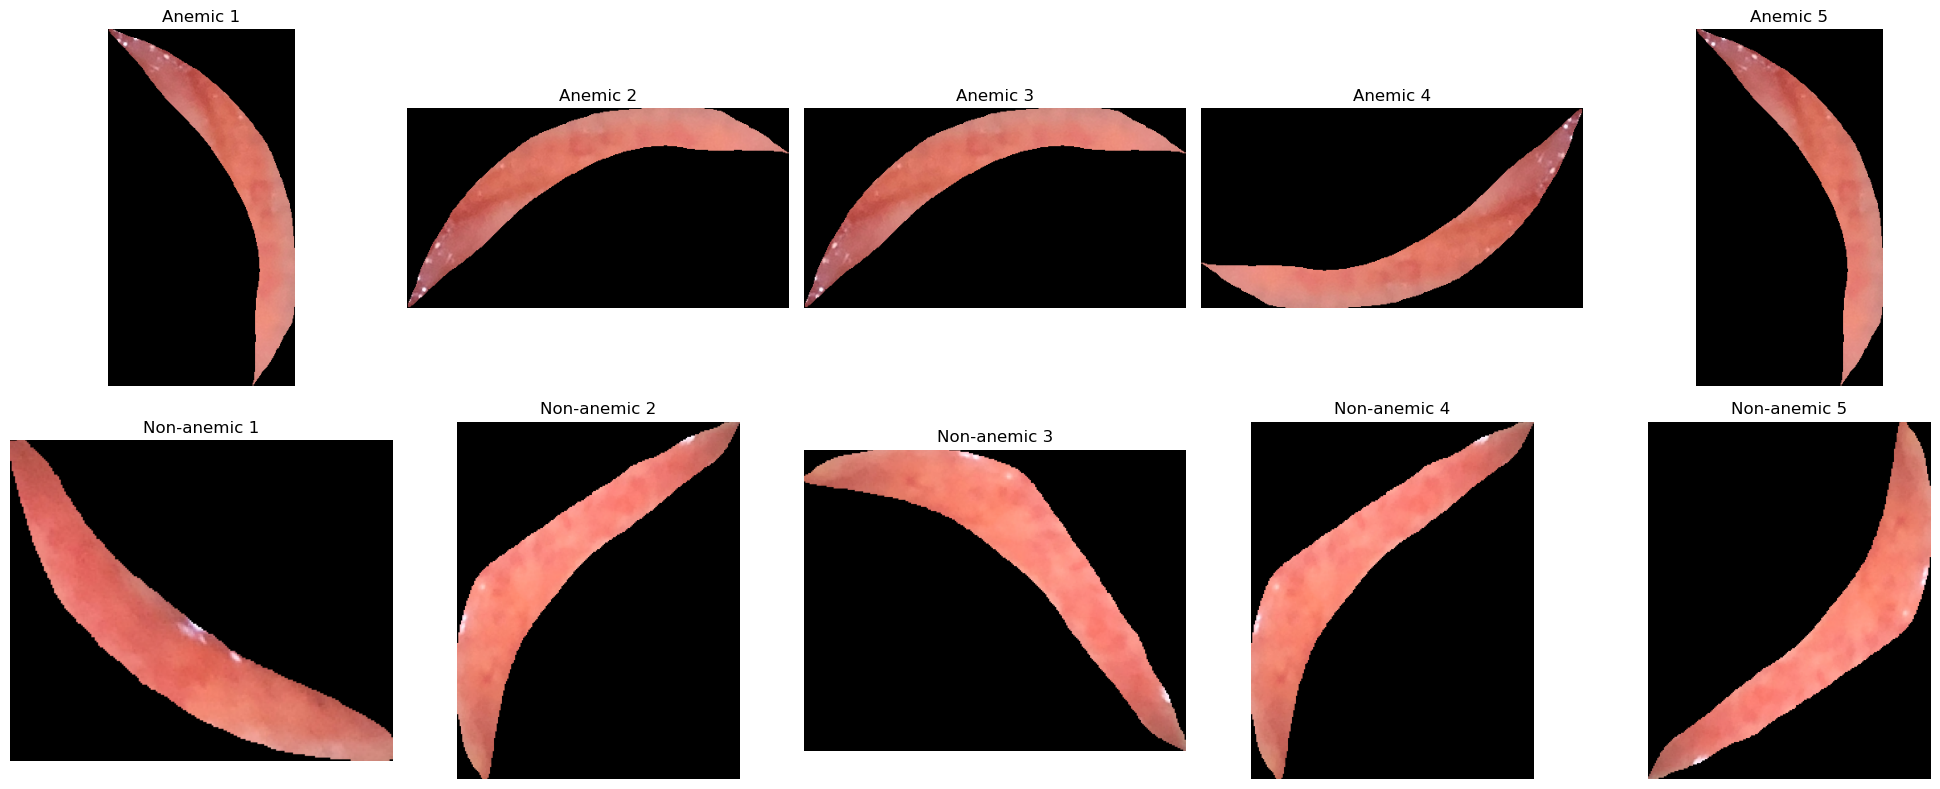

In [8]:
# Visualisasi distribusi warna (contoh untuk beberapa gambar)
def color_analysis(image):
    # Konversikan BGR ke RGB untuk visualisasi yang lebih baik
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Flatten(ratakan) gambar
    pixels = image_rgb.reshape(-1, 3)
    
    # Hitung rata-rata warna
    mean_color = np.mean(pixels, axis=0)
    
    # Hitung warna histogram
    hist_r = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image_rgb], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image_rgb], [2], None, [256], [0, 256])
    
    return mean_color, (hist_r, hist_g, hist_b)

# Analisis sampel gambar
samples_to_show = 5
fig, axes = plt.subplots(2, samples_to_show, figsize=(20, 8))

for i in range(min(samples_to_show, len(anemic_images))):
    axes[0, i].imshow(cv2.cvtColor(anemic_images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f"Anemic {i+1}")
    axes[0, i].axis('off')
    
for i in range(min(samples_to_show, len(nonanemic_images))):
    axes[1, i].imshow(cv2.cvtColor(nonanemic_images[i], cv2.COLOR_BGR2RGB))
    axes[1, i].set_title(f"Non-anemic {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Gambar diatas menunjukkan bentuk struktur yang berbeda antara dua kategori, pada bagian atas terdapat 5 gambar yang diklasifikasikan sebagai anemic, pada bagian bawah diklasifikasikan sebagai nonanemic. 

Gambar anemic menggambarkan ciri-ciri yang terkait dengan kondisi anemia, seperti warna atau tekstur yang berbeda. Sedangkan, gambar nonanemic menunjukkan karakteristik yang lebih normal atau sehat.

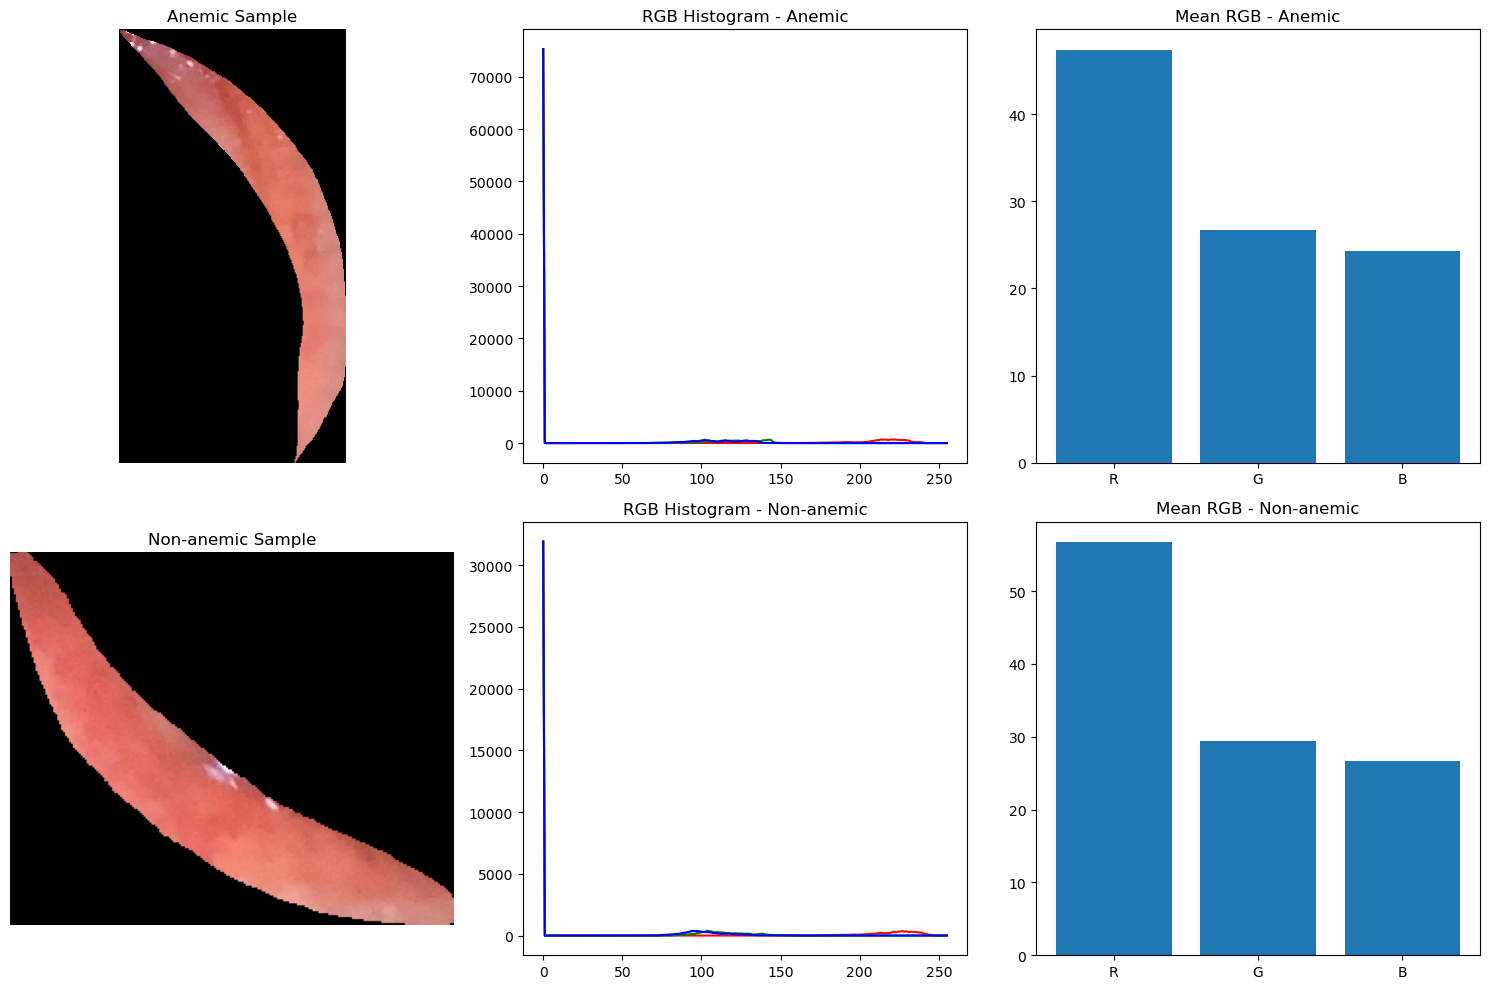

In [9]:
# Analisis histogram warna untuk sampel
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Pilih gambar sampel dari masing-masing kategori
anemic_sample = anemic_images[0] if len(anemic_images) > 0 else None
nonanemic_sample = nonanemic_images[0] if len(nonanemic_images) > 0 else None

if anemic_sample is not None:
    # Tampilkan gambar sampel anemic
    axes[0, 0].imshow(cv2.cvtColor(anemic_sample, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Anemic Sample")
    axes[0, 0].axis('off')
    
    # Analisis warna gambar anemic
    mean_color, (hist_r, hist_g, hist_b) = color_analysis(anemic_sample)
    
    # Plot histogram RGB
    axes[0, 1].plot(hist_r, color='r')
    axes[0, 1].plot(hist_g, color='g')
    axes[0, 1].plot(hist_b, color='b')
    axes[0, 1].set_title("RGB Histogram - Anemic")
    
    # Plot distribusi warna
    axes[0, 2].bar(['R', 'G', 'B'], mean_color)
    axes[0, 2].set_title("Mean RGB - Anemic")

if nonanemic_sample is not None:
    # Tampilkan gambar sampel non-anemic
    axes[1, 0].imshow(cv2.cvtColor(nonanemic_sample, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title("Non-anemic Sample")
    axes[1, 0].axis('off')
    
    # Analisis warna gambar non-anemic
    mean_color, (hist_r, hist_g, hist_b) = color_analysis(nonanemic_sample)
    
    # Plot histogram RGB
    axes[1, 1].plot(hist_r, color='r')
    axes[1, 1].plot(hist_g, color='g')
    axes[1, 1].plot(hist_b, color='b')
    axes[1, 1].set_title("RGB Histogram - Non-anemic")
    
    # Plot distribusi warna
    axes[1, 2].bar(['R', 'G', 'B'], mean_color)
    axes[1, 2].set_title("Mean RGB - Non-anemic")

plt.tight_layout()
plt.show()

Visualisasi diatas menunjukkan pada sebelah kiri terdapat contoh gambar dari setiap kategori, yang menunjukkan adanya perbedaan. Pada histogram RGB pada kategori anemic menunjukkan nilai yang lebih rendah secara keseluruhan, sedangkan histogram nonanemic menunjukkan nilai yang lebih tinggi. 

Grafik rata-rata RGB menunjukkan kategori non-anemic memiliki nilai rata-rata warna yang lebih tinggi dibanding kategori anemic, yang mana ini menunjukkan adanya perbedaan yang signifikan dalam karakteristik visual antara kedua kategori diatas.


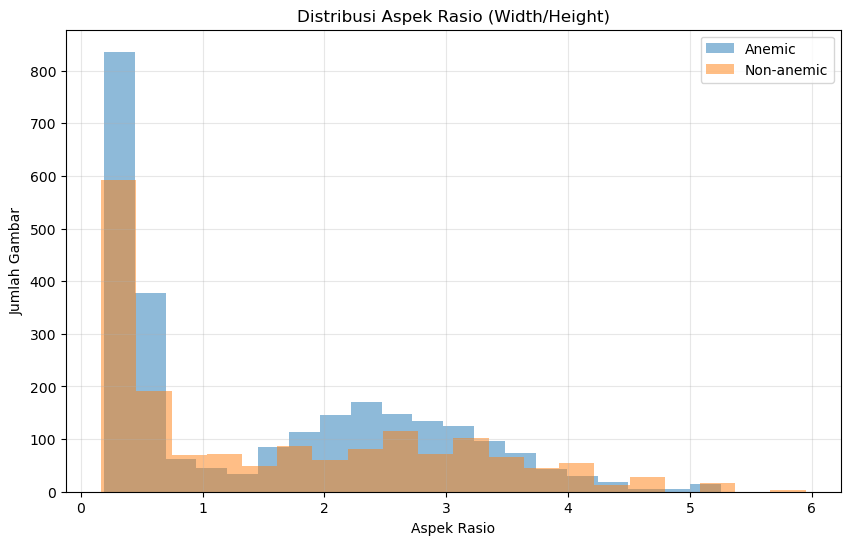

In [10]:
# Analisis distribusi aspek rasio gambar
def analyze_aspect_ratios(images, category):
    ratios = []
    for img in images:
        h, w = img.shape[:2]
        ratio = w / h
        ratios.append(ratio)
    return ratios

anemic_ratios = analyze_aspect_ratios(anemic_images, 'Anemic')
nonanemic_ratios = analyze_aspect_ratios(nonanemic_images, 'Non-anemic')

plt.figure(figsize=(10, 6))
plt.hist(anemic_ratios, alpha=0.5, label='Anemic', bins=20)
plt.hist(nonanemic_ratios, alpha=0.5, label='Non-anemic', bins=20)
plt.title('Distribusi Aspek Rasio (Width/Height)')
plt.xlabel('Aspek Rasio')
plt.ylabel('Jumlah Gambar')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Gambar diatas menunjukkan distribusi rasio aspek gambar (Width/Height). 
- Histogram kategori anemic terdapat pada warna biru menunjukkan puncak yang lebih tinggi dirasio rendah, dengan banyak gambar memiliki rasio mendekati 1. 
- Histogram kategori nonanemic memiliki warna orange, menunjukkan distribusi yang lebih merata dengan beberapa gambar memiliki rasio yang lebih tinggi. 
- Perbedaan diatas menunjukkan gambar anemic memiliki proporsi yang lebih sama, sementara nonanemic memiliki variasi yang lebih besar dalam rasio aspek, menunjukkan perbedaan dalam bentuk atau ukuran antara kedua kategori tersebut.

In [ ]:
### Preprocessing

Preprocessing images...


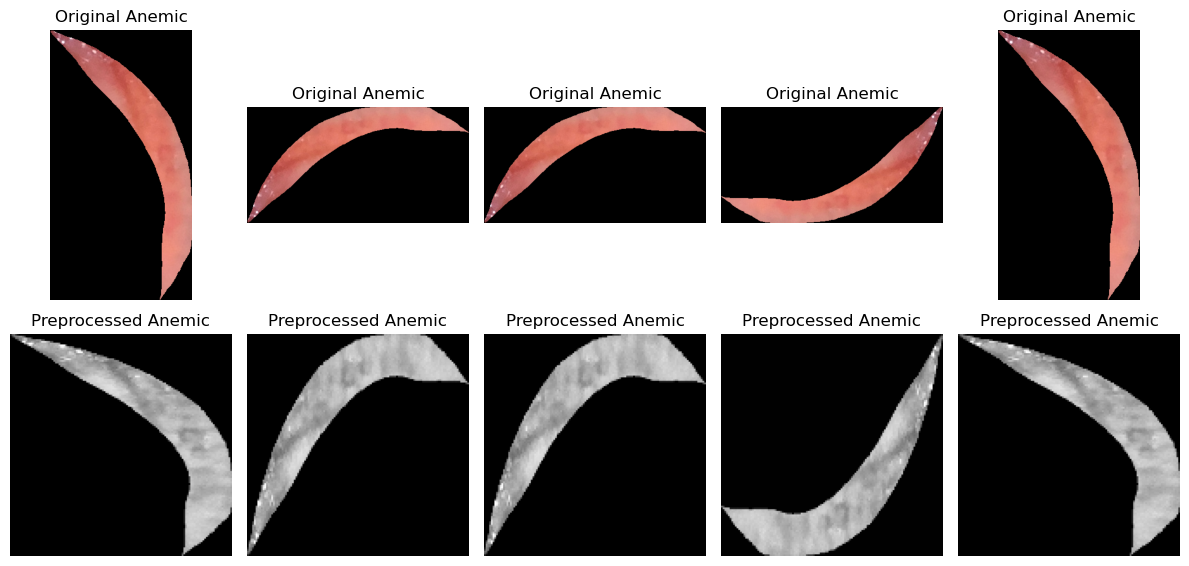

In [ ]:
# Fungsi preprocessing 
def preprocess_images(images, target_size=(128, 128)):
    processed_images = []
    
    for img in images:
        # Resize ke ukuran yang sama
        resized = cv2.resize(img, target_size)
        
        # Konversi ke grayscale
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        
        # Perbaikan kontras dengan CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        
        # Normalisasi nilai piksel ke range [0,1]
        normalized = enhanced / 255.0
        
        processed_images.append(normalized)
    
    return np.array(processed_images)

print("Preprocessing images...")
X_anemic = preprocess_images(anemic_images)
X_nonanemic = preprocess_images(nonanemic_images)

# Visualisasi beberapa gambar hasil preprocessing
plt.figure(figsize=(12, 6))
for i in range(min(5, len(anemic_images))):
    # Gambar original
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(anemic_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Original Anemic')
    plt.axis('off')
    
    # Gambar hasil preprocessing
    plt.subplot(2, 5, i+6)
    plt.imshow(X_anemic[i], cmap='gray')
    plt.title('Preprocessed Anemic')
    plt.axis('off')

plt.tight_layout()
plt.show()

Gambar output diatas menunjukkan perbandingan antara gambar anemic asli dan gambar anemic yang telah diproses. pada baris atas menunjukkan gambar asli dari sampel anemic dengan warna yang lebih jelas, dibaris bawah adalah gambar pre-process anemic, gambar ini menunjukkan sampel yang telah melalui proses pra-pemrosesan, detailnya telah disederhanakan atau diubah untuk analisis lebih lanjut.

Perbedaaan ini mencerminkan efek dari pra-pemrosesan yang dapat meningkatkan konsistensi atau menekankan fitur tertentu dalam gambar untuk memudahkan pengenalan pola atau klasifikasi dalam analisis data medis.

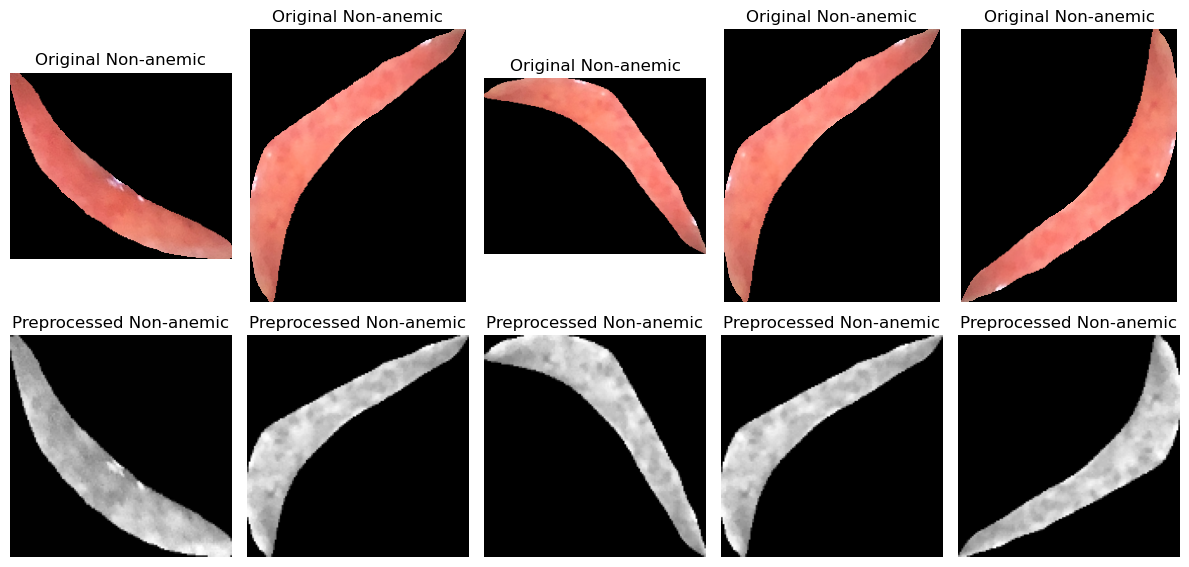

In [12]:
# Visualisasi beberapa gambar non-anemic
plt.figure(figsize=(12, 6))
for i in range(min(5, len(nonanemic_images))):
    # Gambar original
    plt.subplot(2, 5, i+1)
    plt.imshow(cv2.cvtColor(nonanemic_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Original Non-anemic')
    plt.axis('off')
    
    # Gambar hasil preprocessing
    plt.subplot(2, 5, i+6)
    plt.imshow(X_nonanemic[i], cmap='gray')
    plt.title('Preprocessed Non-anemic')
    plt.axis('off')

plt.tight_layout()
plt.show()

Output gambar diatas menunjukkan perbandingan antara gambar nonanemic asli dan gambar nonanemic yang telah diproses.
Perbedaan antara kedua baris ini menggambarkan dampak pra-pemrosesan dalam menonjolkan fitur tertentu atau mengurangi kebisingan dalam gambar, yang dapat membantu dalam pengenalan pola dan klasifikasi dalam konteks analisis medis.

In [13]:
y_anemic = np.ones(len(X_anemic))
y_nonanemic = np.zeros(len(X_nonanemic))

X = np.concatenate((X_anemic, X_nonanemic), axis=0)
y = np.concatenate((y_anemic, y_nonanemic), axis=0)

# Reshape untuk model ML tradisional (flatten gambar)
X_flat = X.reshape(X.shape[0], -1)
print(f"Shape data setelah flatten: {X_flat.shape}")

Shape data setelah flatten: (4277, 16384)


Hasil output diatas menunjukkan dimensi dari dataset setelah proses flattening, yang mengubah struktur data menjadi format satu dimensi. Spesifiknya, terdapat 4.277 sampel gambar yang telah diratakan menjadi vektor dengan 16.384 fitur untuk setiap gambar

In [ ]:
### Training Model SVM

In [14]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Jumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Jumlah data training: 2993
Jumlah data testing: 1284


Hasil output ini menunjukkan pembagian dataset menjadi dua, yaitu data training dan data testing. 
2.993 sampel digunakan untuk pelatihan model, dengan tujuan mengajarkan model mengenali pola dan fitur dalam data. Kemudian, 1.284 sampel digunakan untuk pengujian, berfungsi untuk mengevaluasi kinerja model setelah dilatih.

In [26]:
# Standardisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Shape data training: {X_train_scaled.shape}")
print(f"Shape data testing: {X_test_scaled.shape}")

Shape data training: (2993, 16384)
Shape data testing: (1284, 16384)


Hasil output ini menunjukkan dimensi dataset training dan testing setelah proses flattening. 

Pada data training, terdapat 2.993 sampel yang masing-masing direpresentasikan sebagai vektor dengan 16.384 fitur, sedangkan untuk data testing, terdapat 1.284 sampel. Dimensi ini menunjukkan bahwa setiap gambar, setelah diratakan, memiliki 16.384 fitur yang dapat digunakan oleh model machine learning untuk analisis dan klasifikasi. 

In [ ]:
print("\n--- Training SVM Model ---")
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)


--- Training SVM Model ---


SVC(random_state=42)

Output ini menunjukkan bahwa SVM sedang dalam proses pelatihan. Model yang digunakan adalah kelas Support Vector Classification (SVC), yang merupakan implementasi dari SVM untuk klasifikasi. Pada output tersebut, dapat dilihat bahwa model dikonfigurasi dengan parameter random_state=42, yang bertujuan untuk memastikan reproduktifitas hasil. 

In [ ]:
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7516


Output diatas menunjukkan tingkat akurasi model klasifikasi sebesar 0,7516. akurasi 75,16% menunjukkan bahwa model berhasil mengklasifikasikan sekitar 75,16% dari sampel data pengujian dengan benar. 

In [ ]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Confusion Matrix:
[[288 227]
 [ 92 677]]


Hasil output diatas menunjukkan hasil confusion matrix digunakan untuk mengevaluasi kinerja model klasifikasi.

Penjelasan 4 elemen hasil prediksi model:
- TP (True Positives): 677 — jumlah prediksi benar untuk kelas positif.
- TN (True Negatives): 288 — jumlah prediksi benar untuk kelas negatif.
- FP (False Positives): 227 — jumlah prediksi salah untuk kelas negatif (model memprediksi positif padahal negatif).
- FN (False Negatives): 92 — jumlah prediksi salah untuk kelas positif (model memprediksi negatif padahal positif).


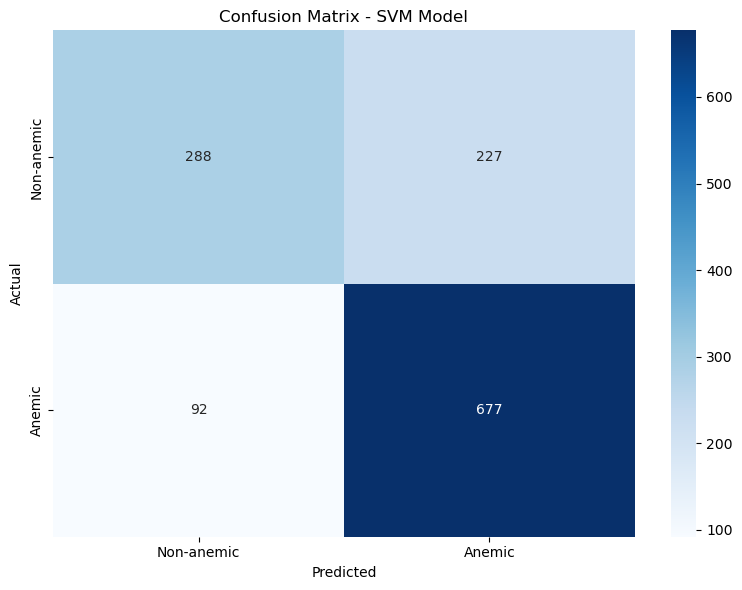

In [ ]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-anemic', 'Anemic'],
            yticklabels=['Non-anemic', 'Anemic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM Model')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png')
plt.show()

Hasil output diatas adalah visualisasi dari confusion matrix untuk model SVM ( sumbu x mewakili prediksi model, sedangkan sumbu y mewakili kelas aktual)

Kelas "Non-anemic" (baris atas):
- 288: Prediksi benar untuk kelas "Non-anemic" (True Negatives, TN).
- 227: Prediksi salah untuk kelas "Non-anemic" (False Positives, FP).

Kelas "Anemic" (baris bawah):
- 92: Prediksi salah untuk kelas "Anemic" (False Negatives, FN).
- 677: Prediksi benar untuk kelas "Anemic" (True Positives, TP).

Warna di dalam plot menunjukkan jumlah prediksi, warna yang lebih gelap menunjukkan nilai yang lebih tinggi yang dapat membantu dalam mengidentifikasi seberapa baik model dalam mengklasifikasikan setiap kelas. 

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-anemic', 'Anemic']))


Classification Report:
              precision    recall  f1-score   support

  Non-anemic       0.76      0.56      0.64       515
      Anemic       0.75      0.88      0.81       769

    accuracy                           0.75      1284
   macro avg       0.75      0.72      0.73      1284
weighted avg       0.75      0.75      0.74      1284



Output diatas adalah laporan klasifikasi yang memberikan metrik evaluasi untuk model klasifikasi. Model ini menunjukkan performa yang baik pada kelas anemic tetapi kurang optimal pada kelas nonanemic.

In [ ]:
# Hyperparameter Tuning dengan GridSearchCV
print("\n--- Performing Hyperparameter Tuning ---")
param_grid = {
    'C': [0.1, 1],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=3,
    verbose=1,
    n_jobs=1
)

grid_search.fit(X_train_scaled, y_train)


--- Performing Hyperparameter Tuning ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=1,
             param_grid={'C': [0.1, 1], 'gamma': ['scale'], 'kernel': ['rbf']},
             verbose=1)

Hasil output diatas menunjukkan proses tuning hyperparameter sedang berlangsung untuk model SVM, dengan tujuan untuk menemukan kombinasi parameter yang memberikan kinerja terbaik.

Penjelasan :
- Performing Hyperparameter Tuning: proses pencarian parameter terbaik untuk model sedang dilakukan.

Fitting 3 folds for each of 2 candidates, totaling 6 fits:
- 3 folds: Data dibagi menjadi tiga bagian (folds) untuk validasi silang. Setiap fold akan digunakan sebagai data pengujian satu kali, sementara dua fold lainnya digunakan untuk pelatihan.
- 2 candidates: Ada dua kombinasi atau set parameter yang sedang dievaluasi.
- Totaling 6 fits: Jumlah total percobaan pelatihan yang dilakukan adalah 6, dihitung sebagai 3 folds dikali 2 candidates.

- GridSearchCV: metode untuk mencari kombinasi parameter terbaik dengan menggunakan validasi silang. 

- Estimator: SVC: model yang digunakan untuk pencarian parameter adalah SVC, yaitu Support Vector Classification.

In [ ]:
# Best parameters 
print("\nBest Parameters:")
print(grid_search.best_params_)



Best Parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


Hasil output ini menunjukkan bahwa kombinasi parameter 𝐶=1, 𝛾=scale, dan 
kernel=rbf adalah yang terbaik untuk model SVM yang telah dilatih.

Penjelasan : 
- C: 1, parameter ini mengontrol trade-off antara mendapatkan margin yang lebih besar dan menghindari kesalahan klasifikasi

- gamma: 'scale', parameter ini mengatur seberapa jauh pengaruh dari satu titik data terhadap titik data lainnya

- kernel: 'rbf', parameter ini menentukan jenis fungsi kernel yang digunakan dalam model SVM. Kernel RBF (Radial Basis Function) efektif untuk data non-linear, karena dapat menangkap hubungan yang kompleks antara fitur-fitur dalam data.

In [ ]:
# Evaluasi model terbaik
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nBest Model Accuracy: {accuracy_best:.4f}")


Best Model Accuracy: 0.7516


Hasil output ini menunjukkan akurasi model terbaik yang diperoleh setelah proses hyperparameter tuning. Akurasi ini dihitung sebagai rasio jumlah prediksi yang benar terhadap total jumlah prediksi yang dilakukan oleh model.

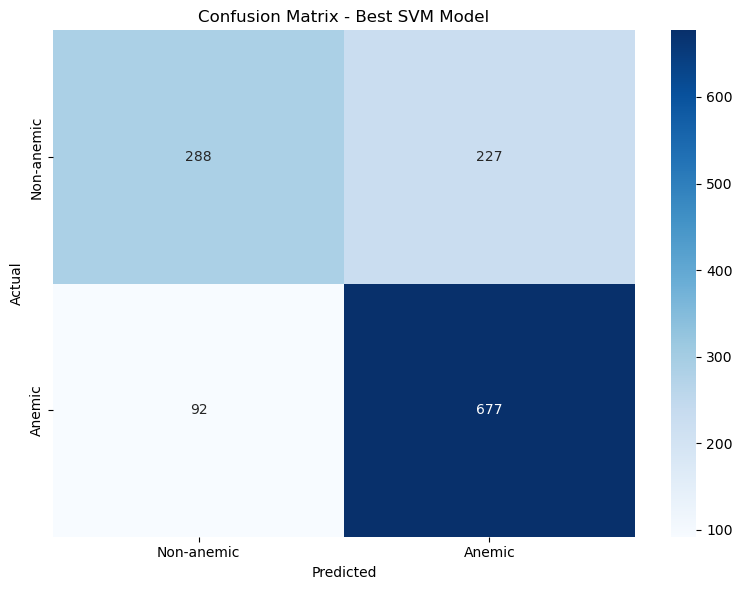

In [ ]:
# Visualisasi Confusion Matrix untuk model terbaik
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-anemic', 'Anemic'],
            yticklabels=['Non-anemic', 'Anemic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best SVM Model')
plt.tight_layout()
plt.savefig('best_svm_confusion_matrix.png')
plt.show()

Hasil output ini menunjukkan visualisasi dari matriks kebingungan (confusion matrix) untuk model SVM terbaik setelah hyperparameter tuning.

Penjelasan :
- warna dalam plot menunjukkan jumlah prediksi, warna lebih gelap menunjukkan nilai lebih tinggi.

- Sumbu X (Predicted):
Menunjukkan kelas yang diprediksi oleh model, yaitu "Non-anemic" dan "Anemic".

- Sumbu Y (Actual):
Menunjukkan kelas sebenarnya dari data, yaitu "Non-anemic" dan "Anemic".

Nilai dalam matriks :
- Non-anemic (baris atas):
- 288: Jumlah prediksi benar untuk kelas "Non-anemic" (True Negatives, TN).
- 227: Jumlah prediksi salah untuk kelas "Non-anemic" (False Positives, FP).

- Anemic (baris bawah):
- 92: Jumlah prediksi salah untuk kelas "Anemic" (False Negatives, FN).
- 677: Jumlah prediksi benar untuk kelas "Anemic" (True Positives, TP).

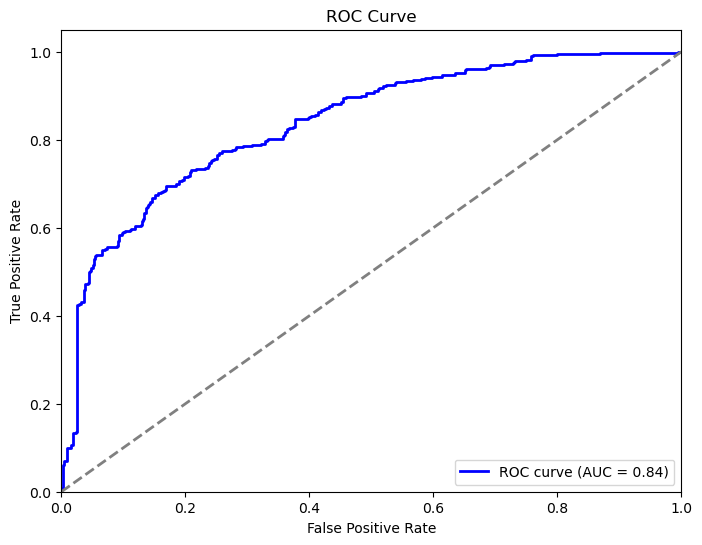

In [ ]:
# Prediksi probabilitas untuk ROC 
y_scores = best_svm.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot kurva ROC 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

Hasil output diatas menunjukkan bahwa model memiliki kinerja yang baik dalam mengklasifikasikan data, dengan AUC sebesar 
0.84. Ini menunjukkan model dapat dengan efektif memisahkan antara kelas "Anemic" dan "Non-anemic". Kurva ROC yang mendekati sudut kiri atas menandakan potensi model yang kuat dalam hal prediksi.

Penjelasan :
- Sumbu X (False Positive Rate)
- Sumbu Y (True Positive Rate)
- Kurva ROC:
Kurva ini menggambarkan hubungan antara tingkat positif benar (True Positive Rate) dan tingkat positif salah (False Positive Rate) pada berbagai ambang batas klasifikasi. Kurva yang lebih dekat ke sudut kiri atas menunjukkan model yang lebih baik.

- AUC (Area Under the Curve)
- AUC = 0.84
AUC adalah ukuran yang menunjukkan seberapa baik model dapat membedakan antara kelas positif dan negatif. 

Nilai AUC berkisar antara 0 hingga 1:
- Nilai 1 model sempurna.
- Nilai 0.5 model tidak lebih baik dari tebakan acak.
- Nilai 0.84 model memiliki kemampuan yang baik dalam membedakan antara kelas positif dan negatif.


Jumlah sampel yang salah diklasifikasi: 319


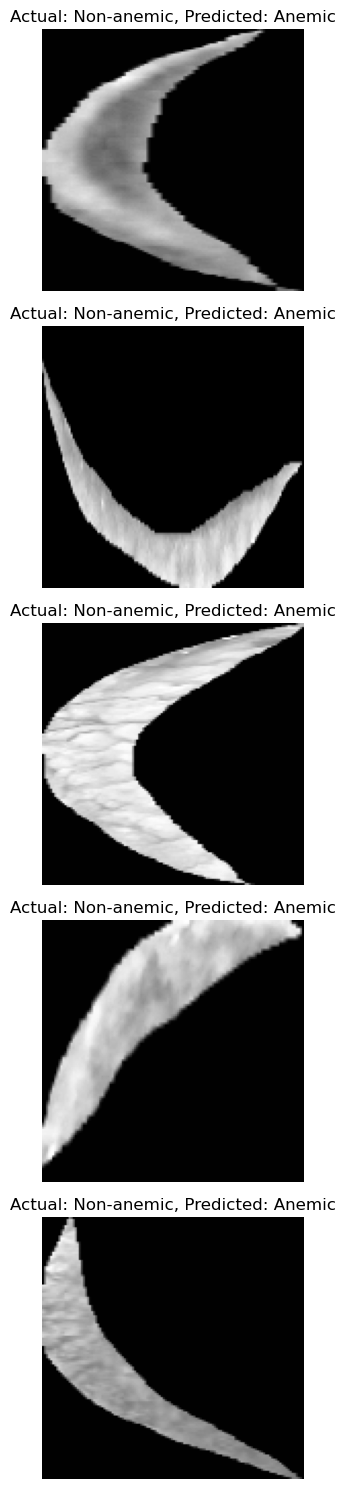

In [33]:
# Analisis Kesalahan Klasifikasi
misclassified_indices = np.where(y_test != y_pred_best)[0]
print(f"\nJumlah sampel yang salah diklasifikasi: {len(misclassified_indices)}")

# Jika ada gambar yang salah diklasifikasi, tampilkan beberapa sebagai contoh
if len(misclassified_indices) > 0:
    # Mendapatkan indeks asli dari data test
    test_indices = np.arange(len(X_test))
    
    # Jika ingin menampilkan gambar yang salah klasifikasi
    # Catatan: perlu dikembalikan ke bentuk gambar asli
    n_samples = min(5, len(misclassified_indices))
    plt.figure(figsize=(15, 3*n_samples))
    
    for i, idx in enumerate(misclassified_indices[:n_samples]):
        img_flat = X_test[idx]
        img_2d = img_flat.reshape(128, 128)  # Sesuaikan dengan ukuran gambar saat preprocessing
        
        actual = "Anemic" if y_test[idx] == 1 else "Non-anemic"
        predicted = "Anemic" if y_pred_best[idx] == 1 else "Non-anemic"
        
        plt.subplot(n_samples, 1, i+1)
        plt.imshow(img_2d, cmap='gray')
        plt.title(f"Actual: {actual}, Predicted: {predicted}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('misclassified_samples.png')
    plt.show()

Hasil output diatas menunjukkan setiap gambar di atas diberi label yang menunjukkan bahwa model memprediksi gambar tersebut sebagai "Anemic", padahal kelas sebenarnya adalah "Non-anemic". Ini menunjukkan kesalahan klasifikasi yang dilakukan oleh model.